# Unsupervised Learning for Astronomy

### Kavli Summer Program in Astrophysics

- Introduction
- Classical Methods
- Autoencoders
- VAEs
- GANs

Slides and code at https://github.com/dkirkby/kavli2019

Based on UC Irvine [Machine Learning & Statistics for Physicists](https://nbviewer.jupyter.org/github/dkirkby/MachineLearningStatistics/blob/master/notebooks/Contents.ipynb) grad course.

### UC Santa Cruz / July 2019

#### David Kirkby dkirkby@uci.edu

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import scipy.stats

from sklearn import decomposition

import torch.nn
import torch.optim
import torch.utils.data

## Introduction

### Themes and Applications

The theme of this lecture is unsupervised learning from astronomical data using neural networks.

We will focus on the following applications:
 - **Dimensionality reduction:** how can I represent my data more efficiently (and then possibly get new insights into its structure)?
 - **Generative modeling:** how can I interpolate / extrapolate a (small, sparse) dataset to generate new data sampled from the same (unknown) distribution?
 - **Probabilistic modeling:** what is the probability that a new observation is drawn from the same (unknown) distribution as some reference (small, sparse) dataset?

Some of the jargon we will cover includes: PCA, VAE, GAN, ...

### Unsupervised Learning

Data consists of a 2D array $X$ of observations (rows) and features (columns).

The essence of **unsupervised** learning is to treat the data holistically (i.e., all features are on an equal footing) and discover patterns.

In contrast, **supervised** learning considers some columns $Y$ as **labels** and learns a map $X\rightarrow Y$ from features to labels.

In the language of probability:
 - **Unsupervised:** learn a joint probability distribution $P(X)$.
 - **Supervised:** learn a conditional probability distribution $P(Y\mid X)$.

### Benchmark Datasets

Progress in machine learning applied to images has benefit enormously from standard public datasets that are well studied and documented, e.g.
 - [MNIST](http://yann.lecun.com/exdb/mnist/): 70K 23 x 23 pixel grayscale images of handwritten digits, labeled with 10 categories.
 - [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html): 60K 32x32 pixel RGB natural images, labeled with 10 categories.
 - [ImageNet](http://image-net.org/challenges/LSVRC/2010/browse-synsets): 200K varying size (avg 469x387) RGB natural images, labeled with 1000 categories.
 
We need comparable resources for astronomy ML research!

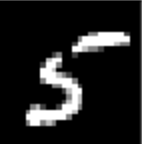
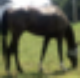
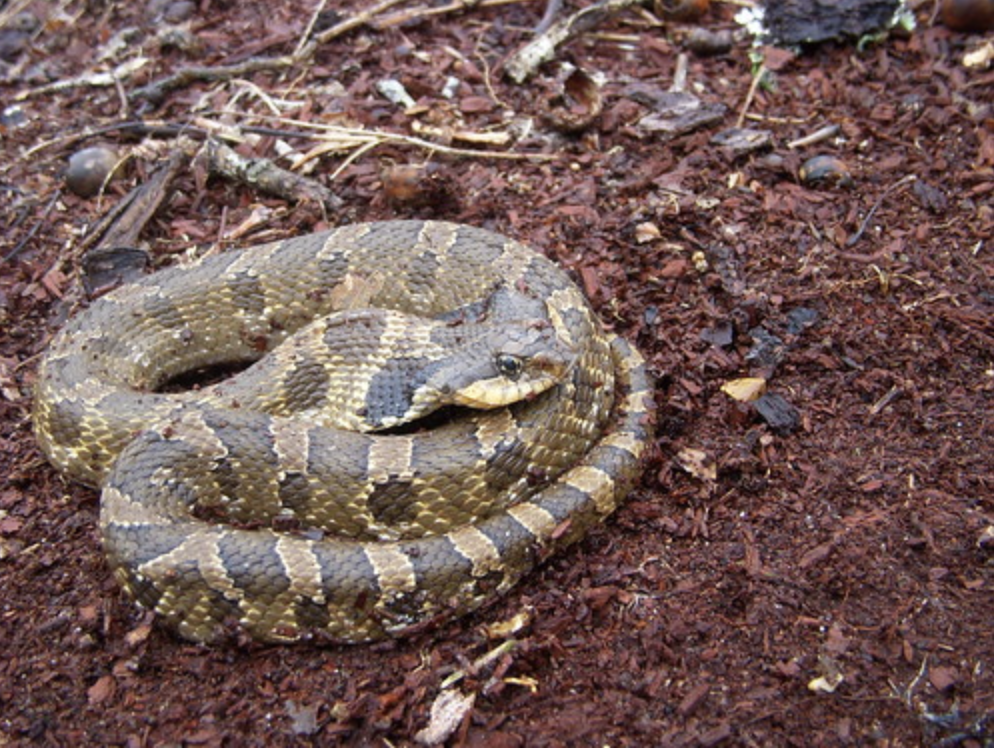

**DISCUSS:** List some ways that astronomical images are different from typical natural images (photos) that might be important for ML?

- Individual objects are small and have relatively simple shapes.
- Objects have diffuse (and transparent) edges.
- Images are often captured with low (known) signal to noise ratio.
- Many filter bands often available but recorded under different conditions (and instruments).
- Background pixels are ~0 (after sky subtraction) and foreground >~ background.
- Label uncertainties are often desirable for downstream analysis.
- Can often simulate our data to generate large datasets with truth labels.

Data augmentation for images:
 - List useful agumentations for a natural image classifier.
 - Discuss whether each is suitable for augmenting postage stamp images of galaxies.
 - refer to fastai augmentation fn
 - mention mixup training? https://arxiv.org/pdf/1812.01187.pdf

Astro images and spectra usually have reliable "ivar" weights associated with each pixel value, derived from the underlying photon counting statistics and calibrated instrumental noise sources.

**DISCUSS:** How can these be used to improve performance when using architectures originally designed for natural images without weights?

Ideas:
 - Add weights as an extra channel.
 - Use weights in loss function, to calculate chi-square instead of MSE.
 - Can studies strategies by varying input SNR in simulated data or by adding noise to real data.

### Test Problem

We start by defining a test problem: learn a generative model of smooth 1D functions drawn from a Gaussian process prior:

In [2]:
def gpsample(x, ngen, gen, sig0=0.5, lam=0.5):
    # Tabulate the covariance K for each pair of elements in x.
    K = sig0 ** 2 * np.exp(-0.5 * ((x.reshape(-1, 1) - x) / lam) ** 2)
    # Generate random samples of f(x).
    return gen.multivariate_normal(np.zeros_like(x), K, size=ngen)

Generate independent TRAIN and TEST samples from the same prior:

In [3]:
N_train, N_test, D = 10000, 100, 128
x_sample = np.linspace(-1, 1, D)
gen = np.random.RandomState(seed=123)

X_train = gpsample(x_sample, ngen=N_train, gen=gen)
X_test = gpsample(x_sample, ngen=N_test, gen=gen)

In [4]:
x_train = torch.tensor(X_train.astype(np.float32))
x_test = torch.tensor(X_test.astype(np.float32))

train_data = torch.utils.data.TensorDataset(x_train, x_train)
test_data = torch.utils.data.TensorDataset(x_test, x_test)

In [5]:
def plot_test(y_pred=None, n_test=3):
    plt.figure(figsize=(10, 4))
    for i in range(n_test):
        x, y = test_data[i]
        plt.plot(x_sample, x.numpy(), '-', lw=3, alpha=0.5, label='INPUT=TARGET' if i == 0 else None)
        if y_pred is not None:
            plt.plot(x_sample, y_pred[i].detach().numpy(), 'k.', ms=2, label='OUTPUT' if i == 0 else None)
    plt.legend(ncol=3)

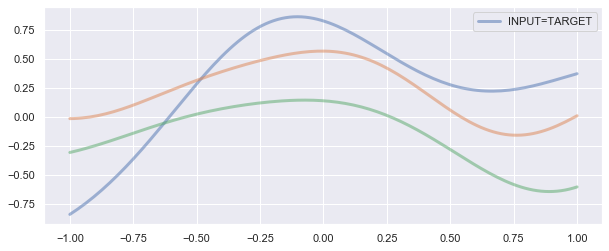

In [6]:
plot_test()

## Classical Methods

The classical approaches to dimensionality reduction seek a linear decomposition that best explains the observations $X$ in terms of latent variables $Y$:

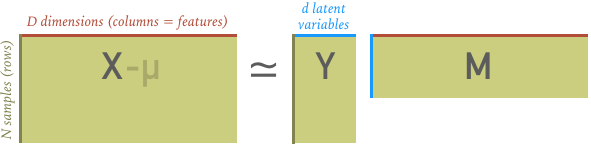

A linear decomposition is not exact (hence the $\simeq$ above) and there is no "best" prescription for determining $Y$ and $M$. The most popular prescriptions implemented in [sklearn.decomposition](http://scikit-learn.org/stable/modules/decomposition.html) are:
 - [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) ([sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html))
 - [Factor Analysis](https://en.wikipedia.org/wiki/Factor_analysis) ([sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html))
 - [Non-negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization) ([sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html))
 - [Independent Component Analysis](https://en.wikipedia.org/wiki/Independent_component_analysis) ([sklearn docs](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html))

All methods require that you specify a key hyperparameter: the number of latent variables $d$.

Perform a PCA decomposition of our test problem's training sample, reducing from 128 to 6 dimensions:

In [7]:
method = decomposition.PCA(n_components=6)
fit = method.fit(X_train)

Transform the data to the 6D latent space:

In [8]:
z_latent = fit.transform(X_train)

In [9]:
pca_cols = [f'z{k}' for k in range(6)]
pca = pd.DataFrame(z_latent[:100], columns=pca_cols)

Plot the data distribution in the latent space:

In [10]:
def pairplot(data, **kwargs):
    g = sns.pairplot(data, height=1.25, diag_kind='hist', diag_kws={'histtype': 'step'}, **kwargs)
    try:
        g._legend.remove()
    except AttributeError:
        pass
    plt.tight_layout()

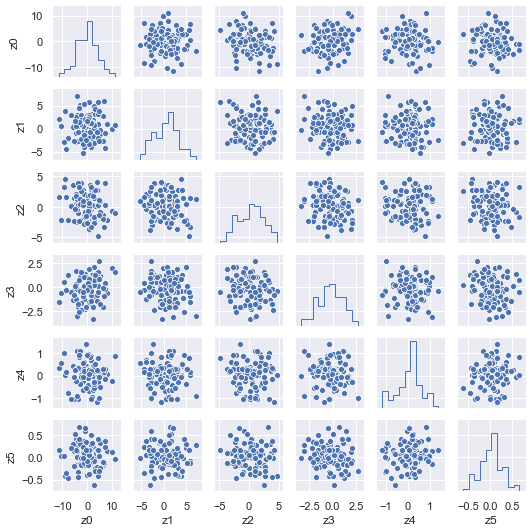

In [11]:
pairplot(pca)

To assess the PCA quality, project latent points back into the original data space:

In [12]:
X_reconstructed = fit.inverse_transform(z_latent)

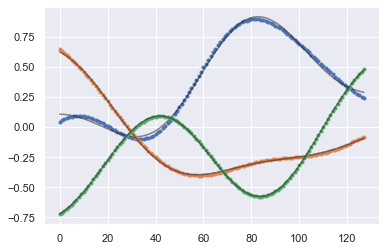

In [13]:
for i in range(3):
    plt.plot(X_train[i], '.')
    plt.plot(X_reconstructed[i], 'k-', alpha=0.5)

What if we add some noise to the training data before peforming PCA?

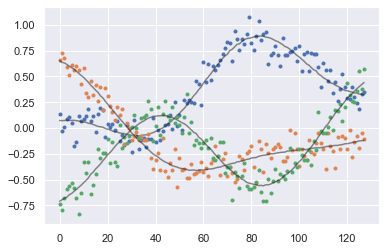

In [14]:
X_noisy = X_train + 0.1 * gen.normal(size=X_train.shape)

fit = method.fit(X_noisy)
z_latent = fit.transform(X_noisy)
X_reconstructed = fit.inverse_transform(z_latent)

for i in range(3):
    plt.plot(X_noisy[i], '.')
    plt.plot(X_reconstructed[i], 'k-', alpha=0.5)

## Auto-Encoder

An **autoencoder** is any network with identical input and output shapes that is trained to reproduce each input at its output:

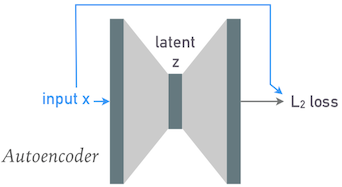

Gray shaded regions represent arbitrary network layers, with heights indicating tensor dimensionality.

Note how the input and output heights are the same.

A fully connected network with $N=128$ inputs and $N=128$ outputs does a great job:

In [15]:
class FCN(torch.nn.Sequential):
    
    def __init__(self, *n_nodes, activation=torch.nn.ReLU):
        super(FCN, self).__init__()
        n_inputs = n_nodes[:-1]
        n_outputs = n_nodes[1:]
        for depth, (n_inp, n_out) in enumerate(zip(n_inputs, n_outputs)):
            self.add_module(f'LYR{depth}', torch.nn.Linear(n_inp, n_out))
            if depth < len(n_inputs) - 1:
                self.add_module(f'ACT{depth}', torch.nn.LeakyReLU(0.2, inplace=True))

In [16]:
def learn(model, loss_fn=torch.nn.MSELoss(), n_epochs=100, batch_size=250, learning_rate=0.002, n_print=1):
    print(f'Model has {np.sum([np.prod(P.shape) for P in model.parameters()])} parameters.')
    loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    x_test, y_test = test_data.tensors
    train_loss, test_loss = [], []
    print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
    for epoch in range(n_epochs):
        model.train()
        for x_train, y_train in loader:
            y_pred = model(x_train)
            loss = loss_fn(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss.append(float(loss.data))
        model.eval()
        y_pred = model(x_test)
        test_loss.append(float(loss_fn(y_pred, y_test).data))
        if epoch + 1 == print_at[0]:
            print(f'EPOCH {epoch + 1:5d}: TRAIN {train_loss[-1]:.5f} TEST {test_loss[-1]:.5f}')
            print_at = print_at[1:]
    plt.figure(figsize=(10, 4))
    plt.plot(train_loss, '.', label='TRAIN')
    plt.plot(test_loss, '.', label='TEST')
    plt.xlabel('Number of Epochs')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.legend()
    return train_loss, test_loss, y_pred.detach()

In [17]:
torch.manual_seed(123);

Model has 16512 parameters.
Data has 1280000 values.
EPOCH   100: TRAIN 0.00000 TEST 0.00000


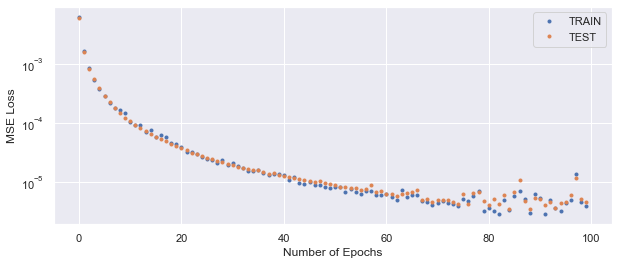

In [18]:
model = FCN(128, 128)
train_loss, test_loss, y_pred = learn(model, n_epochs=100)

Unfortunately it has just learned the identity function $X_\text{out} = X_\text{in}$, rather than anything useful about the actual input distribution, $P(X_\text{in})$.

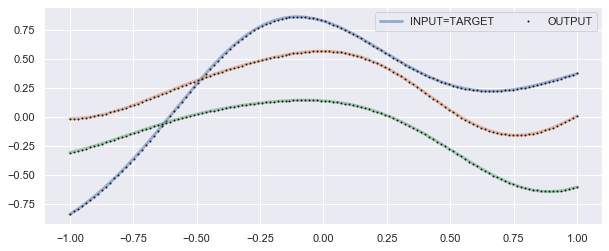

In [19]:
plot_test(y_pred)

In order eliminate this trivial solution, we must force the network to learn a representation of the input data in a lower dimensional "latent" space, then expand this representation back into the original space. With a fully connected network, this just means having hidden layers with less than 128 nodes.

For example, if we add a single hidden layer with 6 nodes we can learn a 6-parameter model that approximates the true Gaussian process prior:

In [20]:
torch.manual_seed(123);

Model has 1670 parameters.
Data has 1280000 values.
EPOCH   200: TRAIN 0.00010 TEST 0.00011


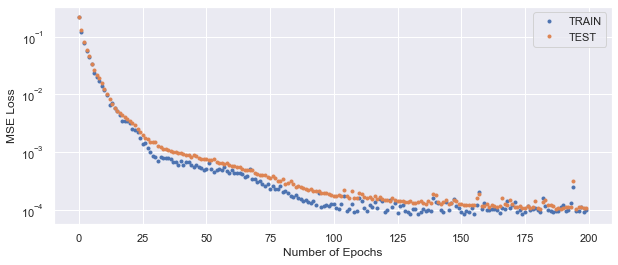

In [21]:
model = FCN(128, 6, 128)
train_loss, test_loss, y_pred = learn(model, n_epochs=200)

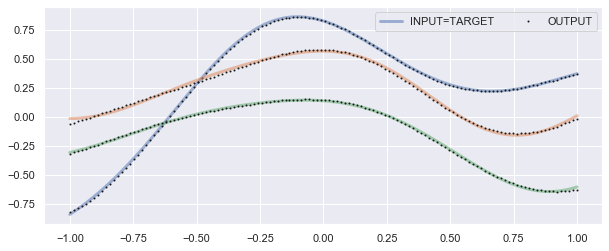

In [22]:
plot_test(y_pred)

In [23]:
import functools

def sizes_as_string(tensors):
    if isinstance(tensors, torch.Tensor):
        return str(tuple(tensors.size()))
    else:
        return ', '.join([sizes_as_string(T) for T in tensors])

def trace_forward(module, input, output, name='', verbose=False):
    """Implement the module forward hook API.
    
    Parameters
    ----------
    input : tuple or tensor
        Input tensor(s) to this module. We save a detached
        copy to this module's `input` attribute.
    output : tuple or tensor
        Output tensor(s) to this module. We save a detached
        copy to this module's `output` attribute.        
    """
    if isinstance(input, tuple):
        module.input = [I.detach() for I in input]
        if len(module.input) == 1:
            module.input = module.input[0]
    else:
        module.input = input.detach()
    if isinstance(output, tuple):
        module.output = tuple([O.detach() for O in output])
        if len(module.output) == 1:
            module.output = module.output[0]
    else:
        module.output = output.detach()
    if verbose:
        print(f'{name}: IN {sizes_as_string(module.input)} OUT {sizes_as_string(module.output)}')
    
def trace_backward(module, grad_in, grad_out, name='', verbose=False):
    """Implement the module backward hook API.
    Parameters
    ----------
    grad_in : tuple or tensor
        Gradient tensor(s) for each input to this module.
        These are the *outputs* from backwards propagation and we
        ignore them.
    grad_out : tuple or tensor
        Gradient tensor(s) for each output to this module.
        Theser are the *inputs* to backwards propagation and
        we save detached views to the module's `grad` attribute.
        If grad_out is a tuple with only one entry, which is usually
        the case, save the tensor directly.
    """
    if isinstance(grad_out, tuple):
        module.grad = tuple([O.detach() for O in grad_out])
        if len(module.grad) == 1:
            module.grad = module.grad[0]
    else:
        module.grad = grad_out.detach()
    if verbose:
        print(f'{name}: GRAD {sizes_as_string(module.grad)}')

def trace(module, active=True, verbose=False):
    if hasattr(module, '_trace_hooks'):
        # Remove all previous tracing hooks.
        for hook in module._trace_hooks:
            hook.remove()
    if not active:
        return
    module._trace_hooks = []
    for name, submodule in module.named_modules():
        if submodule is module:
            continue
        module._trace_hooks.append(submodule.register_forward_hook(
            functools.partial(trace_forward, name=name, verbose=verbose)))
        module._trace_hooks.append(submodule.register_backward_hook(
            functools.partial(trace_backward, name=name, verbose=verbose)))

What does our input distribution look like when projected into the latent space?

In [24]:
trace(model)
y1 = model(x_train[:100])
z1 = model.ACT0.output
y2 = model(x_test[:100])
z2 = model.ACT0.output

In [25]:
latent_cols = [f'z{k}' for k in range(6)]
latent = pd.DataFrame(torch.cat((z1, z2)).numpy(), columns=latent_cols)
latent['SAMPLE'] = ['TRAIN'] * 100 + ['TEST'] * 100

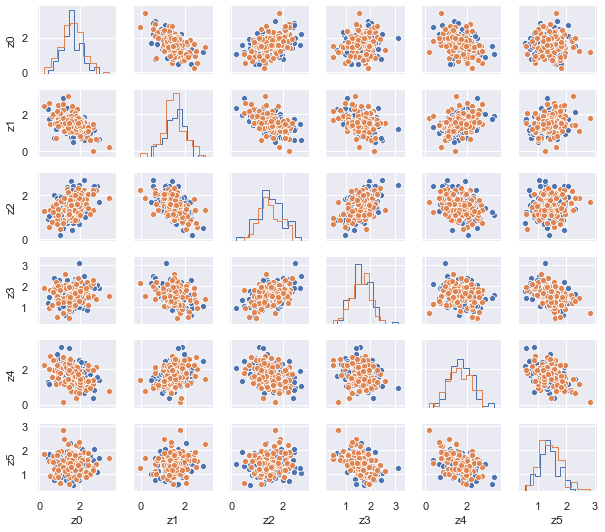

In [26]:
pairplot(latent, hue='SAMPLE')

There are no strong pairwise correlations, which indicates that a 6D latent space is about right.

There is nothing special about using fully connected layers here.  Convolutional layers might work better or, at least, more efficiently.

**DISCUSS:** How might you solve these related problems after learning a latent-space model?
 - Estimate the probability density of an arbitrary input, relative to the input distribution ("probabilistic model").
 - Generate a random sample drawn from the input distribution ("generative model").

**SOLUTION:** Both of these problems could be solved using [density estimation methods](https://nbviewer.jupyter.org/github/dkirkby/MachineLearningStatistics/blob/master/notebooks/Density.ipynb). Given the approximately Gaussian distributions above, a Gaussian mixture model (GMM) would be a good approach.

The density estimated from a GMM fit directly solves the first problem. For the second problem, we need two steps:
 - Generate a sample in the latent space.
 - Feed this sample through the "enlarging" layers of the model, that transform the latent space to the output=input space.

Much of the recent progress in unsupervised deep learning has been to invent network architectures that are capable of solving either or both of these related problems directly, without resorting to any auxiliary methods and making better use of the available input samples (i.e., less likely to memorize a relatively small training sample).

## Variational Autoencoder (VAE)

A VAE breaks the direct connection between the input and output by using the first (reducing) half of the network to map each input to a **distribution of outputs**, instead of to any specific output.

In practice, this means choosing some distribution family in the latent space (usually Gaussian) and then outputting its parameter values, e.g. $\mu$ and $\sigma$.

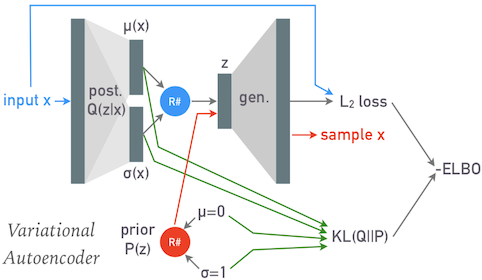

How do we compare a distribution over latent vars with each training example?  The trick is to generate a single random sample $\mathbf{z}$ from the distribution and use this for the comparison.

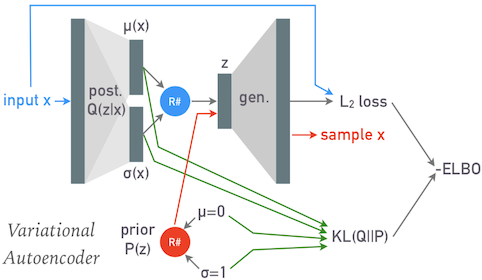

With this recipe, we cannot expect a direct match between the input and output, so what should the loss function be?

The key insight of VAE is that we are actually performing variational inference here, which then tells us what the loss function should be...

In [27]:
class VAE(torch.nn.Module):
    
    def __init__(self, n_data=128, n_latent=6):
        super(VAE, self).__init__()
        self.n_latent = n_latent
        # The posterior inference calculates (mu, logvar) for the posterior probability
        # of a sample in the latent space.
        self.posterior_pre = torch.nn.Sequential(
            torch.nn.Linear(n_data, n_data // 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
        )
        self.posterior_mu = torch.nn.Linear(n_data // 2, n_latent)
        self.posterior_logvar = torch.nn.Linear(n_data // 2, n_latent)
        # The generator maps from the latent space to the data space.
        self.generate = torch.nn.Sequential(
            torch.nn.Linear(n_latent, n_data // 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(n_data // 2, n_data),
        )
        self.eval_z = None
        
    def infer(self, x):
        pre = self.posterior_pre(x)
        return self.posterior_mu(pre), self.posterior_logvar(pre)
    
    def sample(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mu)
        return mu + eps * sigma
    
    def evaluate(self, n_eval=3, fixed_z=True):
        self.eval()
        # Generate n_eval samples from the prior.
        if self.eval_z is None or not fixed_z:
            self.eval_z = torch.randn((n_eval, self.n_latent))
        x = self.generate(self.eval_z).detach()
        for i in range(n_eval):
            plt.plot(x[i].numpy(), '.')
        
    def learn(self, data, alpha=1., n_epochs=100, batch_size=250, learning_rate=0.00005, n_print=1):
        print(f'Model has {np.sum([np.prod(P.shape) for P in self.parameters()])} parameters.')
        loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
        NLL_losses, KL_losses, losses = [], [], []
        self.train()
        l2_loss = torch.nn.MSELoss(reduction='sum')
        for epoch in range(n_epochs):
            for x_train, _ in loader:
                # Infer a Gaussian estimate of each sample's posterior in the latent space.
                mu, logvar = self.infer(x_train)
                # Sample new latent variables from the estimated posteriors.
                z = self.sample(mu, logvar)
                # Generate corresponding samples to compare with the training input.
                x_generated = self.generate(z)
                # Calculate the "reconstruction loss" between the generated and target samples,
                # which equals the ensemble mean of the negative log-likelihood of the target
                # data over the posterior distribution of z, up to some unknown scale factor.
                NLL = l2_loss(x_generated, x_train)
                # Calculate the KL(Q||P) divergence between the variational estimate of the
                # posterior Q(z), specified by mu and logvar, and the (unit normal) prior P(z).
                KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                # Combine these pieces for an estimate of the -ELBO.
                loss = alpha * NLL + KL
                # Update the inference and generator parameters.
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            NLL_losses.append(float(NLL.data))
            KL_losses.append(float(KL.data))
            losses.append(float(loss.data))
            if epoch + 1 == print_at[0]:
                print(f'EPOCH {epoch + 1:5d}: NLL {NLL_losses[-1]:.1f} KL(Q||P) {KL_losses[-1]:.1f} -ELBO {losses[-1]:.1f}')
                print_at = print_at[1:]
        plt.figure(figsize=(10, 4))
        plt.plot(NLL_losses, '.', label='NLL')
        plt.plot(KL_losses, '.', label='KL(Q||P)')
        plt.plot(losses, '.', label='-ELBO')
        plt.xlabel('Number of Epochs')
        plt.ylabel('VAE Loss')
        plt.yscale('log')
        plt.legend()
        return losses, mu.detach(), torch.exp(0.5 * logvar.detach())

Build a VAE for our test problem:

In [28]:
torch.manual_seed(123);

In [29]:
model = VAE(n_data=128, n_latent=6)

Before any training, the outputs are random:

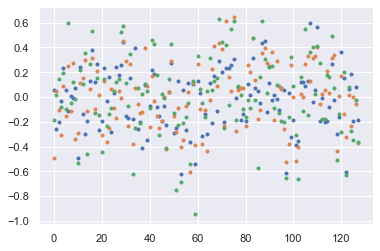

In [30]:
model.evaluate()

The training loss combines NLL and KL terms:

Model has 17804 parameters.
Data has 1280000 values.
EPOCH   100: NLL 823.6 KL(Q||P) 1257.4 -ELBO 2081.0


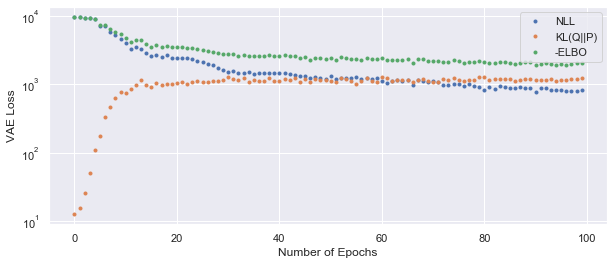

In [31]:
losses, mu, sigma = model.learn(train_data)

The trained model generates samples with the correct large-scale structure, but too much small-scale variance:

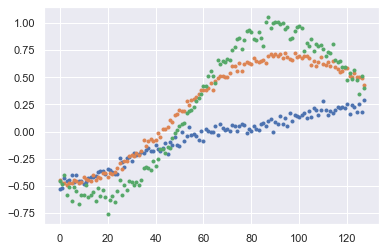

In [32]:
model.evaluate()

### VAE Theory

The first (reducing) half of a VAE network encodes each input sample $\mathbf{x}$ with two parameters $\mu$ and $\sigma$ that define a normal distribution in the (smaller) latent space. We can interpret this normal distribution $Q(\mathbf{z})$ as an estimate of the posterior probability density
$$
Q(\mathbf{z}; \Theta) \simeq P(\mathbf{z}\mid \mathbf{x})
$$
where the latent variables $\mathbf{z}$ play the role of our model parameters and $\Theta$ represents the weights and biases that determine $\mu$ and $\sigma$.

Learning $Q$ by varying $\Theta$ is therefore equivalent to finding the the "best" variational approximation $Q(\mathbf{z}; \Theta)$ to the true posterior $P(\mathbf{z}\mid \mathbf{x})$. 

We saw earlier that the KL divergence between $Q$ and $P$ is a good definition of "best", and that it is equivalent to minimize the negative ELBO:
$$
-\text{ELBO} = \langle \log P(\mathbf{x}\mid \mathbf{z})\rangle_{z\sim Q} +
\text{KL}\left(Q(\mathbf{z};\Theta) \parallel P(\mathbf{z})\right) \; ,
$$
where $P(\mathbf{z})$ is our assumed prior on the latent space.

Note that a VAE attempts to find a $\Theta$ that does a good job of approximating the posterior for *any* input $\mathbf{x}$, rather than for just one observation.

The first term of the -ELBO is the average negative-log-likelihood of $\mathbf{x}$ for model parameters $\mathbf{z}$ drawn from the normal distribution $Q$ (with $\mu$ and $\sigma$ calculated by the network).

We could estimate this with many samples drawn from $Q$ for each input $\mathbf{x}$ but, in practice, it is sufficient to use a single sample $\mathbf{z}$ and let the many iterations of training provide the necessary ensemble averaging.

What is the likelihood $P(\mathbf{x}\mid\mathbf{z})$? We use the second (expanding) network to estimate this quantity, by trying to reconstruct $\mathbf{x}$ from the sample $\mathbf{z}\sim Q$.

A sample $\mathbf{x}$ has high likelihood if it can be accurately reconstructed via the chain:
$$
\mathbf{x}_\text{in} \rightarrow (\mu,\sigma) \rightarrow \mathbf{z}\sim {\cal N}(\mu, \sigma)
\rightarrow \mathbf{x}_\text{out} \; .
$$

We can measure reconstruction accuracy with the $L_2$ loss,
$$
L_2\left(\mathbf{x}_\text{in}, \mathbf{x}_\text{out}\right) =
\left| \mathbf{x}_\text{out} - \mathbf{x}_\text{in}\right|^2 \; ,
$$
which equals the negative-log-likelihood (up to a constant) under the assumption that the uncertainties in each input feature are all drawn from the same normal distribution with variance $\sigma_x^2$,
$$
-\log P(\mathbf{x_\text{in}}\mid \mathbf{z}) = \frac{1}{2\sigma_x^2} L_2\left(
\mathbf{x}_\text{in}, \mathbf{x}_\text{out}\right) \; .
$$

In practice, this assumption is not strictly valid but we still use $L_2$ as a proxy for the likelihood and replace $1/(2\sigma_x^2)$ with an additional hyperparameter $\alpha$:
$$
-\log P(\mathbf{x_\text{in}}\mid \mathbf{z}) \simeq \alpha L_2\left(
\mathbf{x}_\text{in}, \mathbf{x}_\text{out}\right) \; .
$$

Note that when you know something about the input errors, you may be able to build a more accurate likelihood proxy.

The second term of the -EBLO is the KL divergence between $Q$ and our assumed prior, which we chose to be a unit normal so that this term can be calculated analytically:
$$
\text{KL}\left(Q(\mathbf{z};\Theta) \parallel P(\mathbf{z})\right) =
\frac{1}{2} \sum_i \left( \mu_i^2 + \sigma_i^2 - \log\sigma_i^2 - 1\right) \; ,
$$
where the sum is over the latent dimensions of $\mathbf{z}$.

Put the pieces together to construct a loss function that approximates the -ELBO, so our training loop is effectively performing variational inference to find neural network parameters (not to be confused with the probabilistic model parameters $\mathbf{z}$) that are best able to explain the data using a combination of posterior inference in $\mathbf{z}$ and reconstruction $\mathbf{z}\rightarrow\mathbf{x}$.

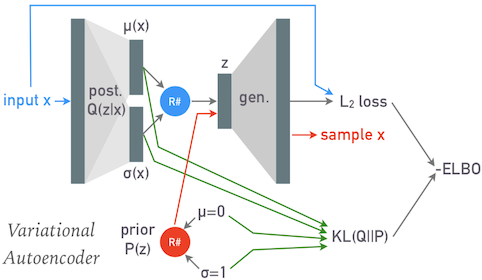

Note that by fixing the prior to a unit normal, we are reversing the way we normally build a model, which is to define the parameters first then chose a suitable prior. Instead, here we are specifying the prior first and then learning a set of parameters that can explain the data with this prior.

## Generative Adversarial Networks (GAN)

A GAN consists of two separate models:
 - A **discriminator** whose job is to classify samples as being real or fake.
 - A **generator** whose job is to map a point $\mathbf{z}$ in the latent space to a corresponding sample $\mathbf{x}$.

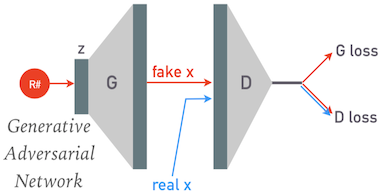

The discriminator (D) and generator (G) are both randomly initialized, then *carefully* trained together so that they both gradually improve together. For each minibatch of the training data we:
 - Generate a corresponding batch of fake samples.
 - Use the discriminator on both the fake and real samples.

We need two loss functions, one for each model.  Both losses measures the classification accuracy of the discriminator (using binary cross entropy):
 - D loss: reward correct classification of both fake and real samples.
 - G loss: reward incorrect classification of fake samples.
 
The ultimate product of a GAN is its generator, and we only use the discriminator to coach the generator. The GAN design is relatively immune to overfitting since the generator is only ever fed random numbers and never directly sees any of the training samples.

In [33]:
class GAN(object):
    
    def __init__(self, n_data=128, n_latent=6, z_norm=False):
        self.n_latent = n_latent
        # The discriminator calculates the probability (as a logit) that a sample is real.
        self.D = torch.nn.Sequential(
            torch.nn.Linear(n_data, n_data // 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(n_data // 2, 1),
        )
        # The generator maps samples in the latent space to the data space.
        self.G = torch.nn.Sequential(
            torch.nn.Linear(n_latent, n_data // 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Linear(n_data // 2, n_data),
        )
        print(f'D has {np.sum([np.prod(P.shape) for P in self.D.parameters()])} parameters.')
        print(f'G has {np.sum([np.prod(P.shape) for P in self.G.parameters()])} parameters.')
        self.eval_z = None
        self.z_norm = z_norm
        
    def get_z(self, n):
        if self.z_norm:
            return torch.randn((n, self.n_latent))
        else:
            return torch.rand((n, self.n_latent))
        
    def evaluate(self, n_eval=3, fixed_z=True):
        self.D.eval()
        self.G.eval()
        # Generate n_eval fakes.
        if self.eval_z is None or not fixed_z:
            self.eval_z = self.get_z(n_eval)
        x = self.G(self.eval_z).detach()
        # Classify each fake sample.
        prob = torch.sigmoid(self.D(x)).detach().squeeze().numpy()
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        # Plot each generated fake labeled with its discriminator probability.
        for i in range(n_eval):
            ax[0].plot(x[i].numpy(), '.', label=f'prob={prob[i]:.5g}')
        ax[0].legend()
        # Fetch the first n_eval samples from the test data.
        x = test_data.tensors[0][:n_eval]
        # Classify each real sample.
        prob = torch.sigmoid(self.D(x)).detach().squeeze().numpy()
        # Plot the first
        for i in range(n_eval):
            ax[1].plot(x[i].numpy(), '.', label=f'prob={prob[i]:.5g}')
        ax[1].legend()
        
    def learn(self, data, n_epochs=200, batch_size=200, D_lr=0.0005, G_lr=0.0005, n_print=1):
        self.D.train()
        self.G.train()
        loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
        D_optimizer = torch.optim.Adam(self.D.parameters(), lr=D_lr)
        G_optimizer = torch.optim.Adam(self.G.parameters(), lr=G_lr)
        D_losses, G_losses = [], []
        print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
        loss_fn = torch.nn.BCEWithLogitsLoss()
        all_real = torch.ones((batch_size, 1))
        all_fake = torch.zeros((batch_size, 1))
        for epoch in range(n_epochs):
            for x_real, _ in loader:
                
                # -- Train the generator ----------------------
                
                # Generate random latent variables for each sample in this minibatch.
                z = self.get_z(batch_size)
                
                # Generate a minibatch of fake samples.
                x_fake = self.G(z)
                
                # Reward the generator for producing fakes that fool the discriminator.
                G_loss = loss_fn(self.D(x_fake), all_real)

                # Update the generator parameters.
                G_optimizer.zero_grad()
                G_loss.backward()
                G_optimizer.step()
                
                # -- Train the discriminator ------------------
                
                # Detach the fake samples from the generator parameters so we can train
                # the discriminator independently.
                x_fake.detach_()

                # Reward the discriminator for correctly classifying fake and real samples.
                D_real_loss = loss_fn(self.D(x_real), all_real)
                D_fake_loss = loss_fn(self.D(x_fake), all_fake)
                D_loss = (D_real_loss + D_fake_loss) / 2

                # Update the discriminator parameters.
                D_optimizer.zero_grad()
                D_loss.backward()
                D_optimizer.step()

            D_losses.append(float(D_loss.data))
            G_losses.append(float(G_loss.data))
            if epoch + 1 == print_at[0]:
                print(f'EPOCH {epoch + 1:5d}: D {D_losses[-1]:.5f} G {G_losses[-1]:.5f}')
                print_at = print_at[1:]
        plt.figure(figsize=(10, 4))
        plt.plot(D_losses, '.', label='D')
        plt.plot(G_losses, '.', label='G')
        plt.xlabel('Number of Epochs')
        plt.ylabel('Adversarial Loss')
        plt.yscale('log')
        plt.legend()
        return D_losses, G_losses

In [34]:
torch.manual_seed(123);

Build a GAN for our test problem with a 6D latent space:

In [35]:
model = GAN(n_data=128, n_latent=6)

D has 8321 parameters.
G has 8768 parameters.


The initial generator's samples are random noise and the initial discriminator guesses that all samples are ~50% likely to be real:

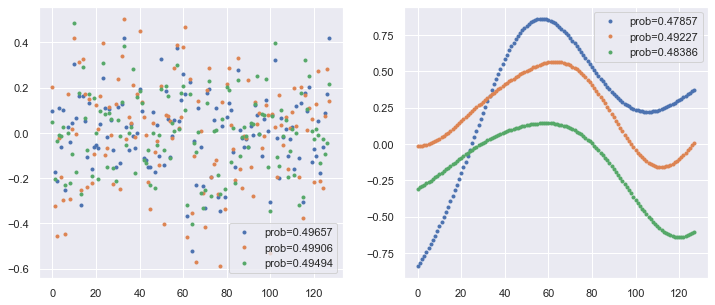

In [36]:
model.evaluate()

Successful learning requires that the separate generator (G) and discriminator (D) losses are comparable, and co-learn to maintain this "adversarial" balance, with neither gaining a clear advantage in this neural-network arms race. This requires some fine tuning and can be challenging to setup and maintain.

Data has 1280000 values.
EPOCH   200: D 0.59528 G 0.77420


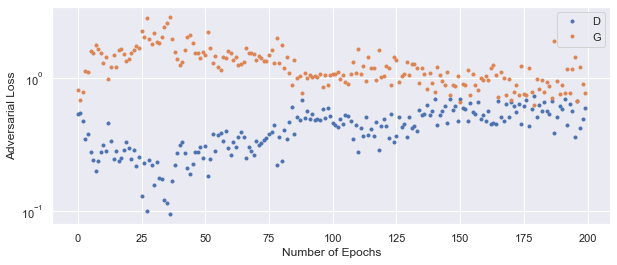

In [37]:
model.learn(train_data, D_lr=0.0005, G_lr=0.0005);

To illustrate how fragile GAN learning can be, repeat the previous study for the same model but using different training hyperparameters:

In [38]:
torch.manual_seed(123);

D has 8321 parameters.
G has 8768 parameters.
Data has 1280000 values.
EPOCH   200: D 0.29736 G 69.00488


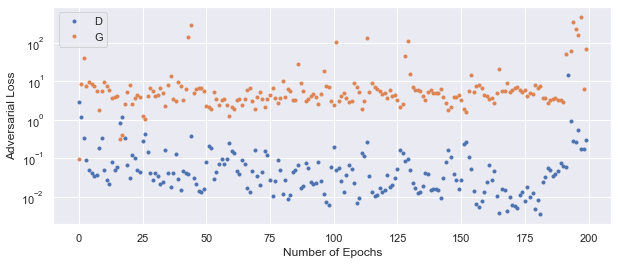

In [39]:
model = GAN(n_data=128, n_latent=6)
model.learn(train_data, D_lr=0.005, G_lr=0.005);

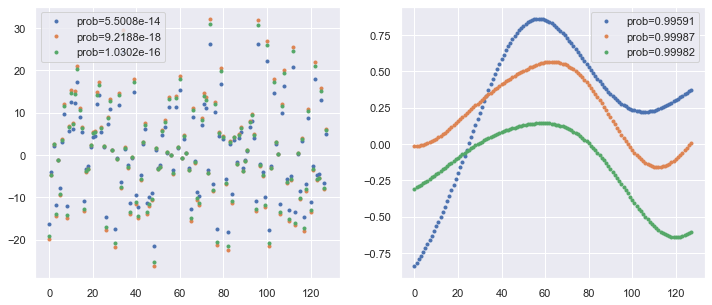

In [40]:
model.evaluate()

**DISCUSS:** Which component (G or D) has effectively won this adversarial contest, preventing further learning? What evidence supports your answer?

**ANSWER:** The discriminator has won. The evidence for this is:
 - The final D loss is ~0.01 while the final G loss is ~100.
 - The final D classifications are essentially perfect: ~0 for the fakes and ~1 for the real samples.
 - The final G samples are highly correlated and indistinguishable from noise.
 
See this [talk](https://www.youtube.com/watch?v=myGAju4L7O8) and accompanying [repo](https://github.com/soumith/ganhacks) for some practical advice on training GANs.

The VAE and GAN architectures both learn a generative model but using very different approaches.

Interestingly, the GAN loss function can be written in a form that makes its connection to VAE more obvious:

$$
\text{VAE loss} = \text{KL}(q\parallel p) + \text{constant}
$$

$$
\text{GAN loss} = \text{JS}(q\parallel p) + \text{constant}
$$

($q$ = generated distribution, $p$ = true data distribution)

"JS" is the Jensen-Shannon divergence, which is a symmetrized forward + reverse KL:
$$
\text{JS}(q\parallel p) = \frac{1}{2}\left[
\text{KL}(q\parallel m) + \text{KL}(p\parallel m)
\right]
$$
where $m = (p+q)/2$.

Another recent development is the realization that the Wasserstein ("earth mover") metric has some [interesting advantages](https://www.alexirpan.com/2017/02/22/wasserstein-gan.html) over KL.

These insights leads to many VAE-GAN variations and hybrids.  For details see the [VEGAN Cookbook](https://arxiv.org/abs/1705.07642).